In [4]:
import pandas as pd

def collatz_step(n):
    return n // 2 if n % 2 == 0 else 3 * n + 1

def nu2(n):
    if n == 0:
        return 0  # or float('inf'), but zero won’t appear in Collatz
    count = 0
    while n % 2 == 0:
        n = n // 2
        count += 1
    return count

def generate_collatz_data(n_max=100):
    all_rows = []
    for start in range(1, n_max + 1):
        n = start
        step = 0
        prev_nu2 = None
        while n != 1:
            current_nu2 = nu2(n)
            delta = None if prev_nu2 is None else current_nu2 - prev_nu2
            all_rows.append({
                'n_start': start,
                'step': step,
                'value': n,
                'nu2': current_nu2,
                'delta_nu2': delta
            })
            prev_nu2 = current_nu2
            n = collatz_step(n)
            step += 1
        # Include the final 1 in the sequence
        current_nu2 = nu2(n)
        delta = None if prev_nu2 is None else current_nu2 - prev_nu2
        all_rows.append({
            'n_start': start,
            'step': step,
            'value': n,
            'nu2': current_nu2,
            'delta_nu2': delta
        })
    return pd.DataFrame(all_rows)

# Generate and save
df = generate_collatz_data(100)
df.to_csv("data/collatz_trajectories.csv", index=False)
df.head(10)


,n_start,step,value,nu2,delta_nu2
0,1,0,1,0,NaN
1,2,0,2,1,NaN
2,2,1,1,0,-1.0
3,3,0,3,0,NaN
4,3,1,10,1,1.0
5,3,2,5,0,-1.0
6,3,3,16,4,4.0
7,3,4,8,3,-1.0
8,3,5,4,2,-1.0
9,3,6,2,1,-1.0


Shannon entropy of nu2 distribution: 2.1524 bits


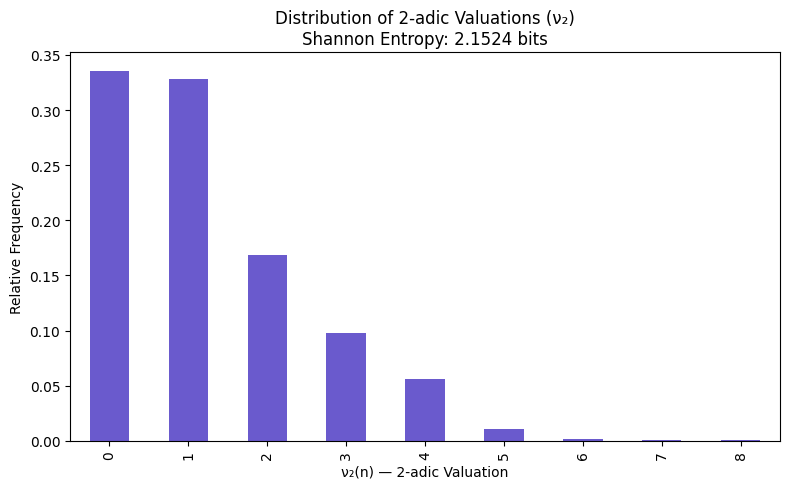

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Load your data
df = pd.read_csv("data/collatz_trajectories.csv")

# Optional: drop the NaN rows if you want to avoid delta_nu2 = NaN rows for now
df_clean = df.dropna(subset=['delta_nu2'])

# Compute distribution of 2-adic valuations (nu2)
nu2_counts = df_clean['nu2'].value_counts(normalize=True).sort_index()

# Compute Shannon entropy
shannon_H = entropy(nu2_counts, base=2)
print(f"Shannon entropy of nu2 distribution: {shannon_H:.4f} bits")

# Plot histogram of nu2 values with Shannon entropy title
plt.figure(figsize=(8, 5))
nu2_counts.plot(kind='bar', color='slateblue')
plt.title(f"Distribution of 2-adic Valuations (ν₂)\nShannon Entropy: {shannon_H:.4f} bits")
plt.xlabel("ν₂(n) — 2-adic Valuation")
plt.ylabel("Relative Frequency")
plt.tight_layout()
plt.savefig("images/nu2_shannon_entropy.png", dpi=150)
plt.show()


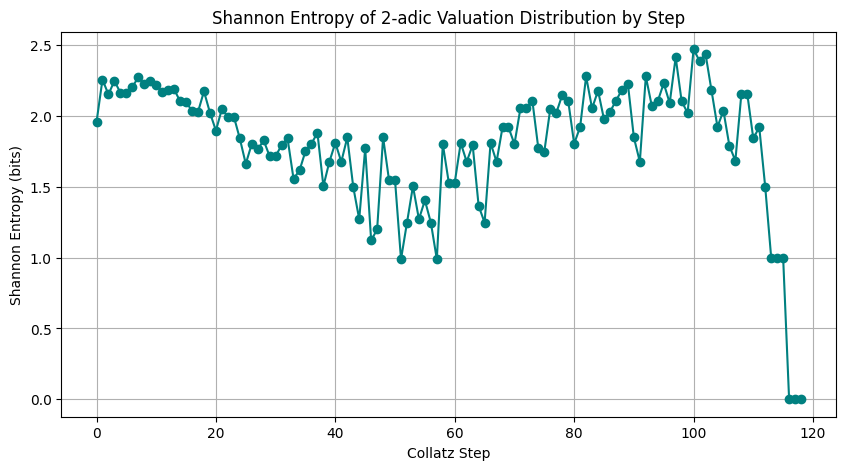

In [6]:
from collections import defaultdict

# Group by step and compute Shannon entropy of nu2 distribution at each step
step_entropy = []
nu2_distributions = defaultdict(list)

max_step = df['step'].max()

for step, group in df.groupby('step'):
    counts = group['nu2'].value_counts(normalize=True).sort_index()
    h = entropy(counts, base=2)
    step_entropy.append((step, h))
    nu2_distributions[step] = counts

# Convert to DataFrame for plotting
entropy_df = pd.DataFrame(step_entropy, columns=["step", "shannon_entropy"])

# Plot entropy over steps
plt.figure(figsize=(10, 5))
plt.plot(entropy_df["step"], entropy_df["shannon_entropy"], marker='o', color='teal')
plt.title("Shannon Entropy of 2-adic Valuation Distribution by Step")
plt.xlabel("Collatz Step")
plt.ylabel("Shannon Entropy (bits)")
plt.grid(True)
plt.savefig("images/stepwise_shannon_entropy.png", dpi=150)
plt.show()


In [7]:
import pandas as pd
import numpy as np

# Load your full trajectory CSV
df = pd.read_csv("data/collatz_trajectories.csv")

# Set embedding dimension
embedding_dim = 20

# Prepare the delay embedding matrix
embedding_rows = []
start_values = []

for n_start, group in df.groupby("n_start"):
    vals = group.sort_values("step")["nu2"].tolist()
    # Truncate or pad with -1
    if len(vals) >= embedding_dim:
        vals = vals[:embedding_dim]
    else:
        vals += [-1] * (embedding_dim - len(vals))
    embedding_rows.append(vals)
    start_values.append(n_start)

# Convert to DataFrame
embedding_df = pd.DataFrame(embedding_rows, index=start_values)
embedding_df.columns = [f"nu2_t{i}" for i in range(embedding_dim)]
embedding_df.index.name = "n_start"

# Save to CSV
embedding_df.to_csv("data/embedding_matrix.csv")
embedding_df.head()


,nu2_t0,nu2_t1,nu2_t2,nu2_t3,nu2_t4,nu2_t5,nu2_t6,nu2_t7,nu2_t8,nu2_t9,nu2_t10,nu2_t11,nu2_t12,nu2_t13,nu2_t14,nu2_t15,nu2_t16,nu2_t17,nu2_t18,nu2_t19
n_start,,,,,,,,,,,,,,,,,,,,
1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,1,0,4,3,2,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,4,3,2,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [8]:
import pandas as pd

# Load the same Collatz trajectory CSV
df = pd.read_csv("data/collatz_trajectories.csv")

# Set embedding dimension (match the ν₂ one if you want)
embedding_dim = 20

# Build delay embedding from raw Collatz values
trajectory_rows = []
start_values = []

for n_start, group in df.groupby("n_start"):
    vals = group.sort_values("step")["value"].tolist()
    # Truncate or pad with -1
    if len(vals) >= embedding_dim:
        vals = vals[:embedding_dim]
    else:
        vals += [-1] * (embedding_dim - len(vals))
    trajectory_rows.append(vals)
    start_values.append(n_start)

# Convert to DataFrame
trajectory_df = pd.DataFrame(trajectory_rows, index=start_values)
trajectory_df.columns = [f"x_t{i}" for i in range(embedding_dim)]
trajectory_df.index.name = "n_start"

# Save to CSV
trajectory_df.to_csv("data/embedding_values.csv")
trajectory_df.head()


,x_t0,x_t1,x_t2,x_t3,x_t4,x_t5,x_t6,x_t7,x_t8,x_t9,x_t10,x_t11,x_t12,x_t13,x_t14,x_t15,x_t16,x_t17,x_t18,x_t19
n_start,,,,,,,,,,,,,,,,,,,,
1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3,10,5,16,8,4,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,5,16,8,4,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


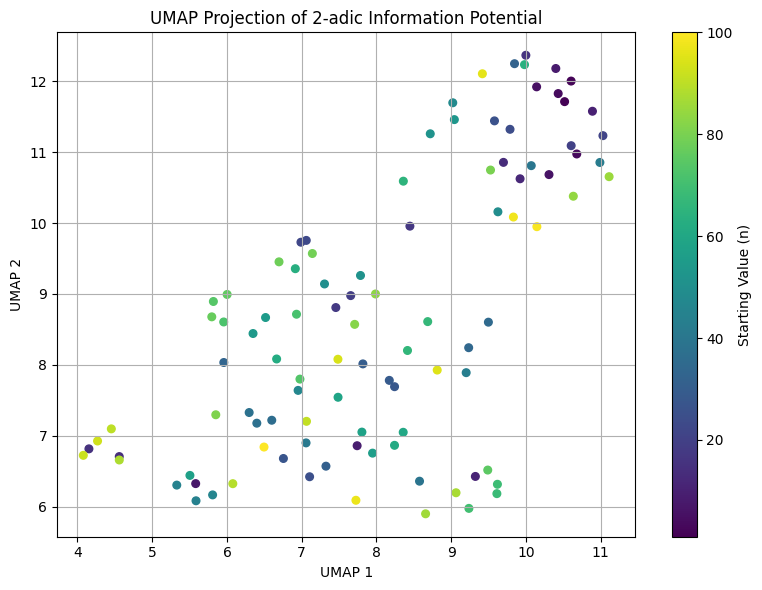

In [10]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load the 2-adic delay embedding
df_nu2 = pd.read_csv("data/embedding_matrix.csv", index_col="n_start")

# Optional: Replace -1 with 0 or normalize — your call
X = df_nu2.replace(-1, 0)  # We assume -1 is padding

# Run UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='manhattan', random_state=42)
embedding = reducer.fit_transform(X)

# Convert to DataFrame for inspection
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["n_start"] = df_nu2.index

# Save to CSV for later
umap_df.to_csv("data/umap_nu2_embedding.csv", index=False)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], s=30, c=umap_df["n_start"], cmap="viridis")
plt.colorbar(label="Starting Value (n)")
plt.title("UMAP Projection of 2-adic Information Potential")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/umap_nu2_embedding.png", dpi=150)
plt.show()


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Temp\ipykernel_19592\3637650581.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", 10)


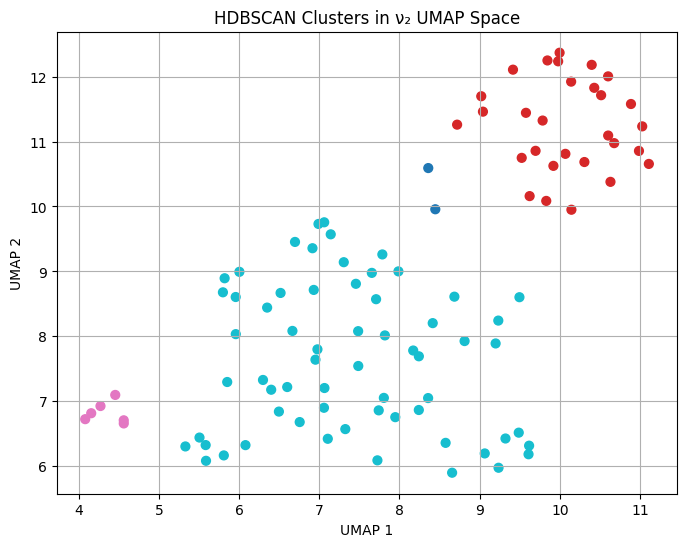

In [11]:
import hdbscan

# Run HDBSCAN on UMAP embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
umap_df["cluster"] = clusterer.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# Save with cluster labels
umap_df.to_csv("data/umap_nu2_hdbscan.csv", index=False)

# Plot
plt.figure(figsize=(8, 6))
palette = plt.cm.get_cmap("tab10", 10)
scatter = plt.scatter(
    umap_df["UMAP1"], umap_df["UMAP2"],
    c=umap_df["cluster"],
    cmap="tab10",
    s=40
)
plt.title("HDBSCAN Clusters in ν₂ UMAP Space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.savefig("images/hdbscan_nu2_clusters.png", dpi=150)
plt.show()


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


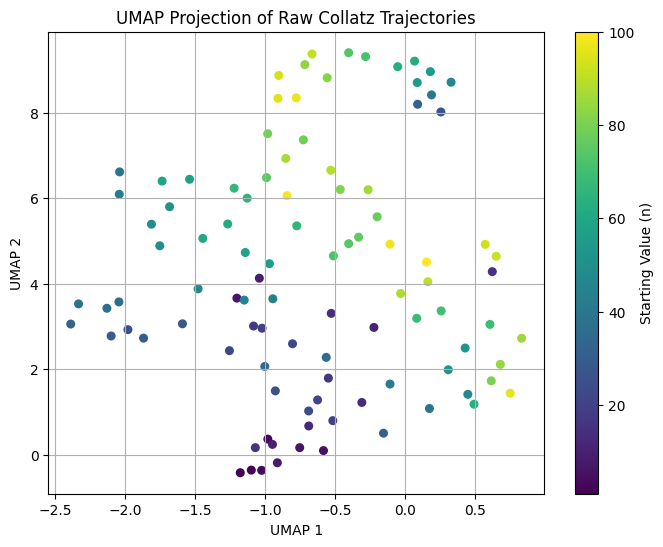

In [12]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load the raw Collatz trajectory embedding
df_x = pd.read_csv("data/embedding_values.csv", index_col="n_start")

# Replace -1 padding with 0 or log(1) if you prefer
X_vals = df_x.replace(-1, 0)

# Optional: Try log-scale if you want energy-style trajectories
# X_vals = X_vals.applymap(lambda x: np.log(x + 1))  # Avoid log(0)

# Run UMAP
reducer_x = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='manhattan', random_state=42)
embedding_x = reducer_x.fit_transform(X_vals)

# Convert to DataFrame
umap_x_df = pd.DataFrame(embedding_x, columns=["UMAP1", "UMAP2"])
umap_x_df["n_start"] = df_x.index

# Save for later use
umap_x_df.to_csv("data/umap_value_embedding.csv", index=False)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(umap_x_df["UMAP1"], umap_x_df["UMAP2"], s=30, c=umap_x_df["n_start"], cmap="viridis")
plt.colorbar(label="Starting Value (n)")
plt.title("UMAP Projection of Raw Collatz Trajectories")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.savefig("images/umap_value_embedding.png", dpi=150)
plt.show()


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


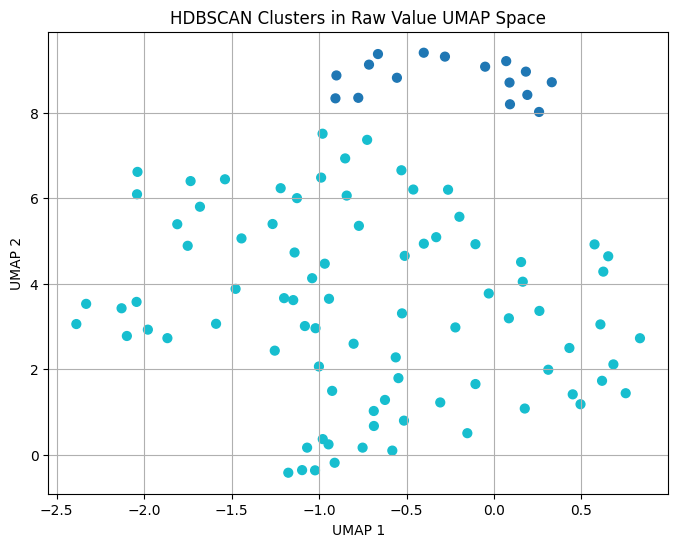

In [13]:
import hdbscan

# Run HDBSCAN on the value-based UMAP embedding
clusterer_val = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
umap_x_df["cluster"] = clusterer_val.fit_predict(umap_x_df[["UMAP1", "UMAP2"]])

# Save to CSV
umap_x_df.to_csv("data/umap_value_hdbscan.csv", index=False)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_x_df["UMAP1"], umap_x_df["UMAP2"],
    c=umap_x_df["cluster"], cmap="tab10", s=40
)
plt.title("HDBSCAN Clusters in Raw Value UMAP Space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.savefig("images/hdbscan_value_clusters.png", dpi=150)
plt.show()


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


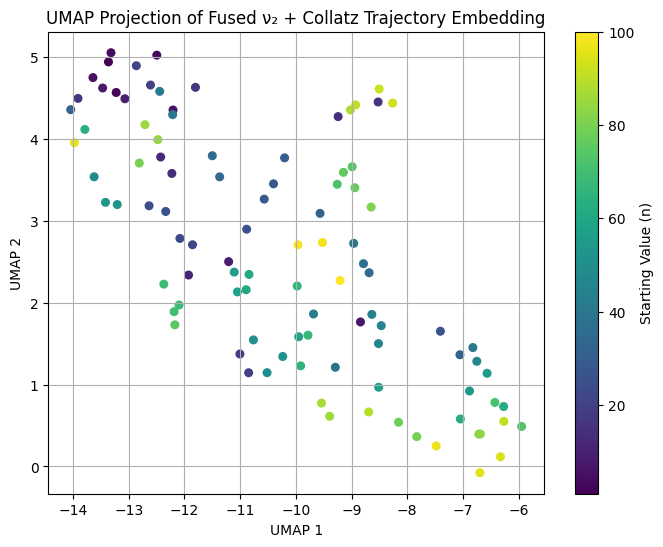

In [18]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load both embeddings
nu2_df = pd.read_csv("data/embedding_matrix.csv", index_col="n_start")
val_df = pd.read_csv("data/embedding_values.csv", index_col="n_start")

# Replace padding -1 with 0 (optional)
nu2_df_clean = nu2_df.replace(-1, 0)
val_df_clean = val_df.replace(-1, 0)

# Optionally normalize each block (to prevent one from dominating)
from sklearn.preprocessing import StandardScaler
nu2_scaled = pd.DataFrame(StandardScaler().fit_transform(nu2_df_clean), index=nu2_df.index)
val_scaled = pd.DataFrame(StandardScaler().fit_transform(val_df_clean), index=val_df.index)

# Combine into one fused feature matrix
fused_df = pd.concat([nu2_scaled, val_scaled], axis=1)

# Run UMAP
reducer_fused = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='manhattan', random_state=42)
embedding_fused = reducer_fused.fit_transform(fused_df)

# Create result DataFrame
umap_fused_df = pd.DataFrame(embedding_fused, columns=["UMAP1", "UMAP2"])
umap_fused_df["n_start"] = fused_df.index

# Save for later
umap_fused_df.to_csv("data/umap_fused_embedding.csv", index=False)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_fused_df["UMAP1"], umap_fused_df["UMAP2"],
    s=30, c=umap_fused_df["n_start"], cmap="viridis"
)
plt.colorbar(label="Starting Value (n)")
plt.title("UMAP Projection of Fused ν₂ + Collatz Trajectory Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.savefig("images/umap_fused_embedding.png", dpi=150)
plt.show()


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


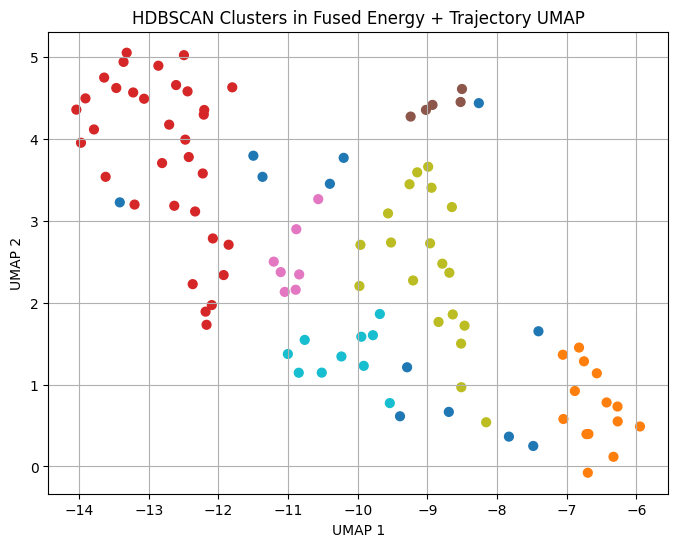

In [29]:
import hdbscan

# Run HDBSCAN on the fused UMAP space
clusterer_fused = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
umap_fused_df["cluster"] = clusterer_fused.fit_predict(umap_fused_df[["UMAP1", "UMAP2"]])

# Save with cluster labels
umap_fused_df.to_csv("data/umap_fused_hdbscan.csv", index=False)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_fused_df["UMAP1"], umap_fused_df["UMAP2"],
    c=umap_fused_df["cluster"], cmap="tab10", s=40
)
plt.title("HDBSCAN Clusters in Fused Energy + Trajectory UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.savefig("images/hdbscan_fused_clusters.png", dpi=150)
plt.show()


In [51]:
# Load UMAP fused embedding (without n_start)
umap_fused_df = pd.read_csv("data/umap_fused_embedding.csv")

# Add n_start if it's missing and row order matches metadata
umap_fused_df["n_start"] = metadata.index.values

# Now you can merge safely
umap_meta_df = umap_fused_df.set_index("n_start").join(metadata)
umap_meta_df.reset_index(inplace=True)

# Save it
umap_meta_df.to_csv("data/umap_fused_with_metadata.csv", index=False)


In [52]:
# Load the full trajectory CSV
df = pd.read_csv("data/collatz_trajectories.csv")

# Precompute metadata per starting value
metadata = df.groupby("n_start").agg({
    "step": "max",
    "value": "max",
    "nu2": ["first", "sum"],
    "delta_nu2": "sum"
})

# Clean up column names
metadata.columns = ["steps_to_1", "max_value", "nu2_0", "nu2_total", "delta_nu2_total"]

# Merge with UMAP
umap_meta_df = umap_fused_df.set_index("n_start").join(metadata)

# Reset index if you want
umap_meta_df.reset_index(inplace=True)

# Save it for analysis
umap_meta_df.to_csv("data/umap_fused_with_metadata.csv", index=False)
umap_meta_df.head()


,n_start,UMAP1,UMAP2,steps_to_1,max_value,nu2_0,nu2_total,delta_nu2_total
0,1,-13.363301,4.937357,0,1,0,0,0.0
1,2,-13.224874,4.564185,1,2,1,1,-1.0
2,3,-12.495957,5.019461,7,16,0,11,0.0
3,4,-13.318064,5.049223,2,4,2,3,-2.0
4,5,-13.641596,4.745865,5,16,0,10,0.0


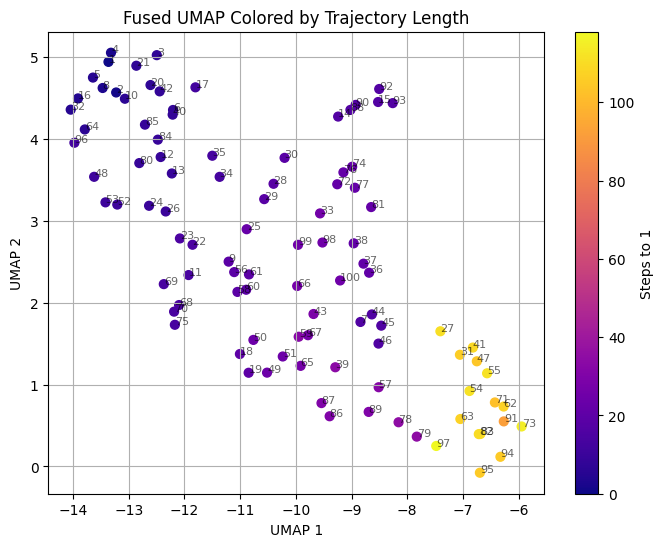

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(
    umap_meta_df["UMAP1"], umap_meta_df["UMAP2"],
    c=umap_meta_df["steps_to_1"],
    cmap="plasma", s=40
)

for _, row in umap_meta_df.iterrows():
    plt.text(row["UMAP1"], row["UMAP2"], str(int(row["n_start"])), fontsize=8, alpha=0.6)

plt.colorbar(label="Steps to 1")
plt.title("Fused UMAP Colored by Trajectory Length")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.savefig("images/umap_fused_steps_colored.png", dpi=150)
plt.show()


In [54]:
# Assuming umap_fused_df is already created and includes HDBSCAN cluster labels
# And you've run the metadata code from earlier

# Load full Collatz trajectory
df = pd.read_csv("data/collatz_trajectories.csv")

# Compute metadata
metadata = df.groupby("n_start").agg({
    "step": "max",
    "value": "max",
    "nu2": ["first", "sum"],
    "delta_nu2": "sum"
})
metadata.columns = ["steps_to_1", "max_value", "nu2_0", "nu2_total", "delta_nu2_total"]

# Merge metadata with fused UMAP + HDBSCAN clusters
umap_fused_df.set_index("n_start", inplace=True)
umap_meta_df = umap_fused_df.join(metadata).reset_index()

# Save for use here
umap_meta_df.to_csv("data/umap_fused_with_metadata.csv", index=False)


In [55]:
# Load both pieces
umap_df = pd.read_csv("data/umap_fused_with_metadata.csv")
hdbscan_df = pd.read_csv("data/umap_fused_hdbscan.csv")  # contains the 'cluster' column

# Merge on n_start (or index if row order matches)
merged_df = umap_df.copy()
merged_df["cluster"] = hdbscan_df["cluster"]  # assuming same row order

# Now group by cluster
cluster_summary = merged_df.groupby("cluster").agg({
    "n_start": ["count", list],
    "steps_to_1": ["mean", "max", "min"],
    "max_value": ["mean", "max"],
    "nu2_0": "mean",
    "delta_nu2_total": "mean"
})

# Flatten column names and reset
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)


In [56]:
df_meta = pd.read_csv("data/umap_fused_with_metadata.csv")
df_clusters = pd.read_csv("data/umap_fused_hdbscan.csv")  # contains 'cluster' column

# Sanity check
print(df_clusters.columns)

# Merge if same order
df_meta["cluster"] = df_clusters["cluster"]

df_meta.to_csv("data/umap_fused_with_metadata_and_clusters.csv", index=False)




Index(['UMAP1', 'UMAP2', 'cluster'], dtype='object')


In [57]:
import pandas as pd

# Load the fused UMAP with metadata and cluster labels
df = pd.read_csv("data/umap_fused_with_metadata.csv")

cluster_summary = df_meta.groupby("cluster").agg({
    "n_start": ["count", list],
    "steps_to_1": ["mean", "max", "min"],
    "max_value": ["mean", "max"],
    "nu2_0": "mean",
    "delta_nu2_total": "mean"
})


# Flatten column names
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)

# Preview the summary
cluster_summary.head()


,cluster,n_start_count,n_start_list,steps_to_1_mean,steps_to_1_max,steps_to_1_min,max_value_mean,max_value_max,nu2_0_mean,delta_nu2_total_mean
0,-1,12,"[27, 28, 30, 34, 35, 39, 53, 79, 86, 89, 93, 97]",37.333333,118,11,1745.000000,9232,0.416667,-0.416667
1,0,14,"[31, 41, 47, 54, 55, 62, 63, 71, 73, 82, 83, 9...",106.857143,115,92,9232.000000,9232,0.285714,-0.285714
2,1,33,"[1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 16, 17, ...",8.727273,15,0,66.878788,340,1.696970,-1.696970
3,2,5,"[14, 15, 88, 90, 92]",17.000000,17,17,119.200000,160,1.400000,-1.400000
4,3,7,"[9, 25, 29, 56, 58, 60, 61]",19.428571,23,18,102.285714,184,0.857143,-0.857143


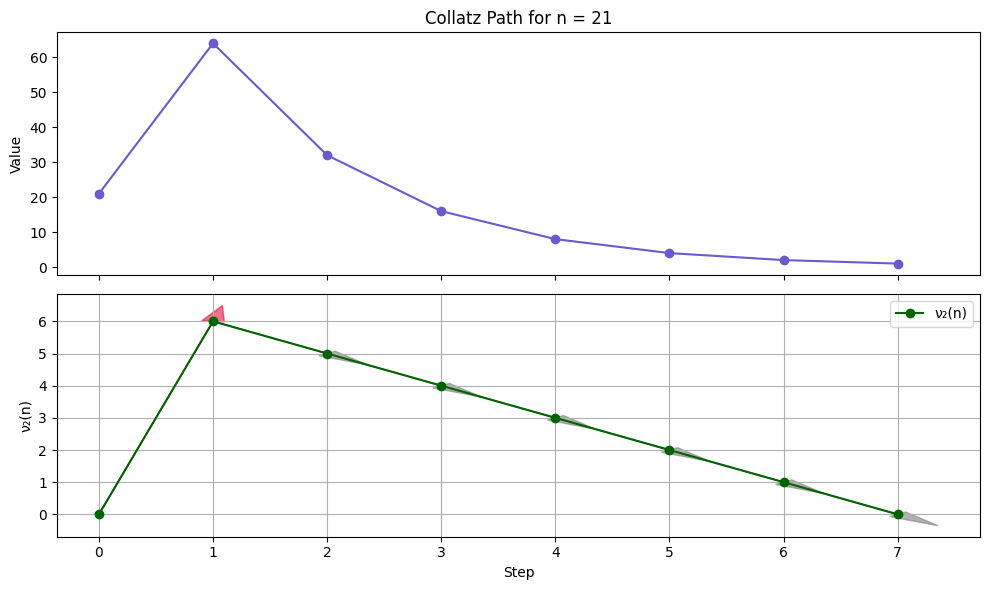

Saved: images/trajectory_cluster_1_n_21.png


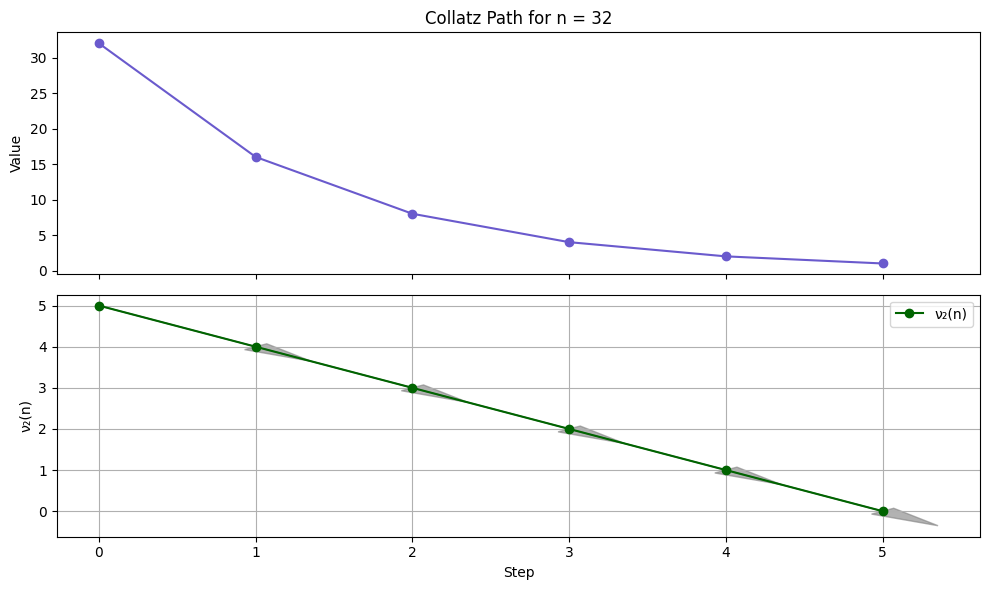

Saved: images/trajectory_cluster_1_n_32.png


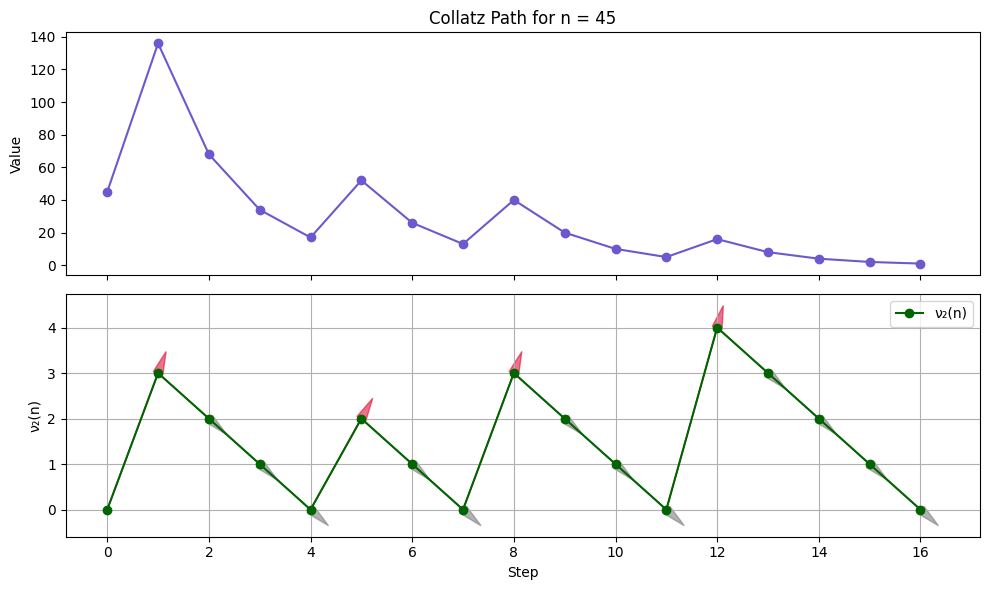

Saved: images/trajectory_cluster_4_n_45.png


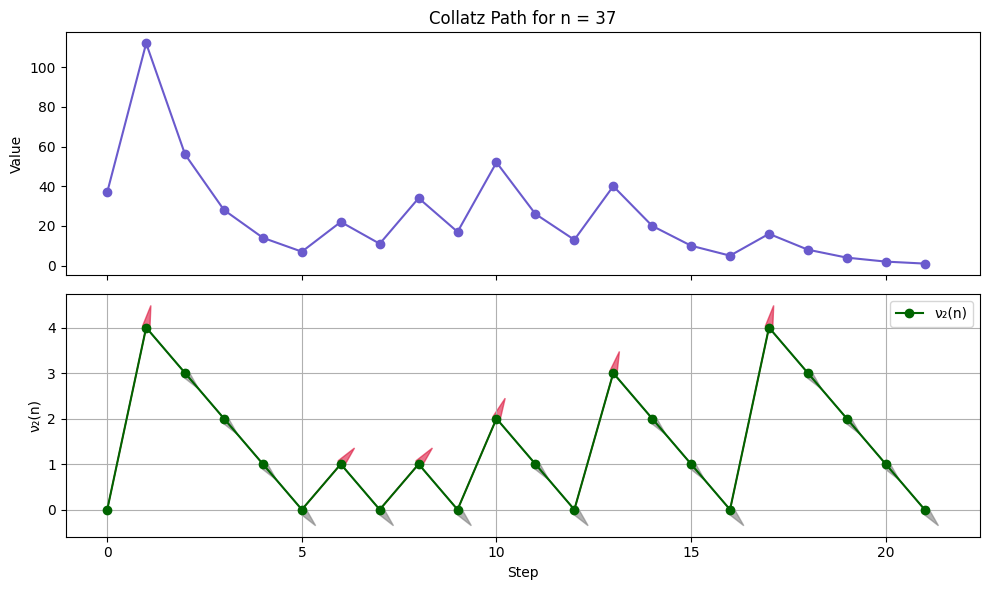

Saved: images/trajectory_cluster_4_n_37.png


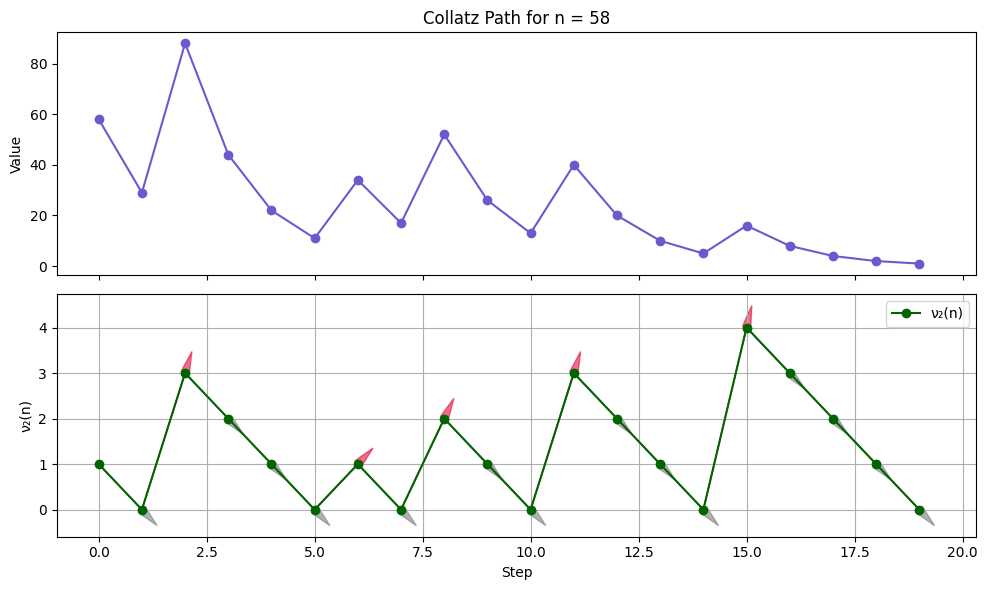

Saved: images/trajectory_cluster_3_n_58.png


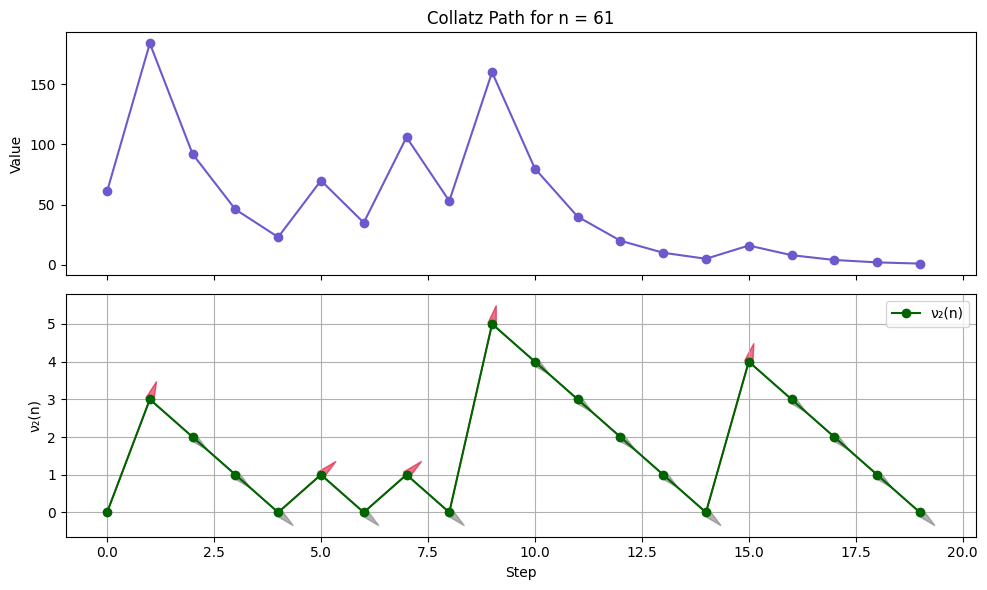

Saved: images/trajectory_cluster_3_n_61.png


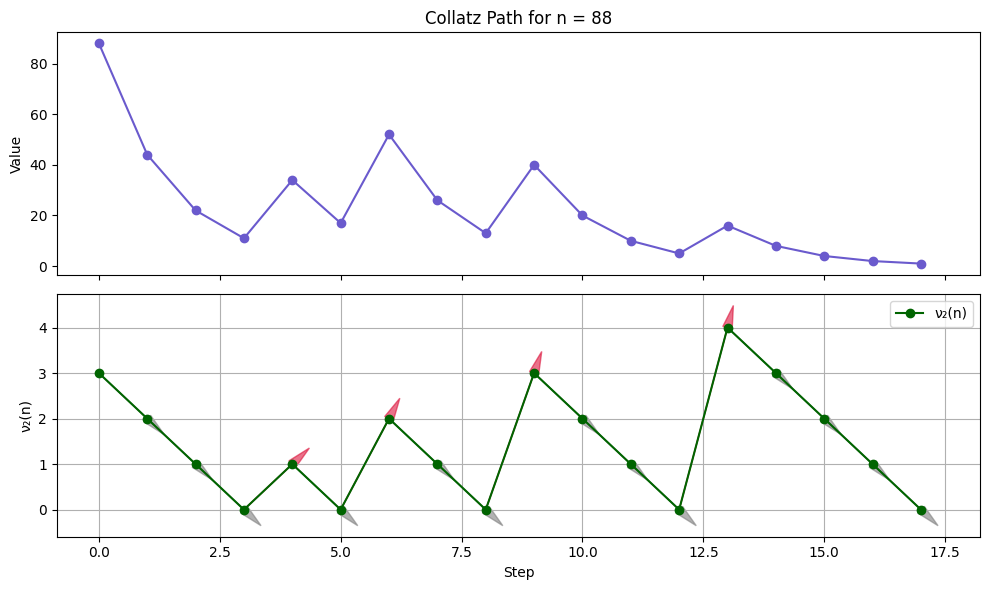

Saved: images/trajectory_cluster_2_n_88.png


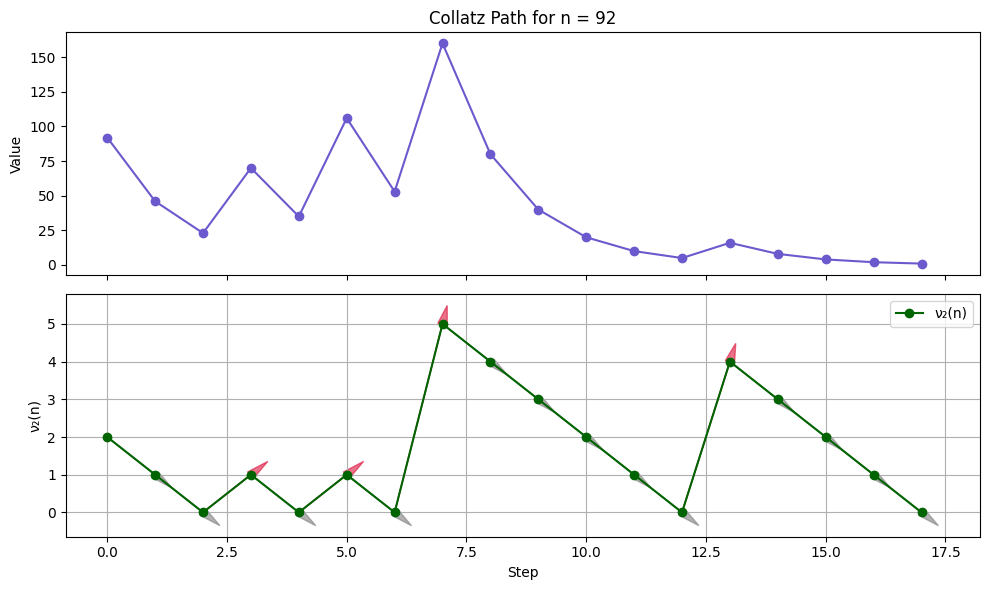

Saved: images/trajectory_cluster_2_n_92.png


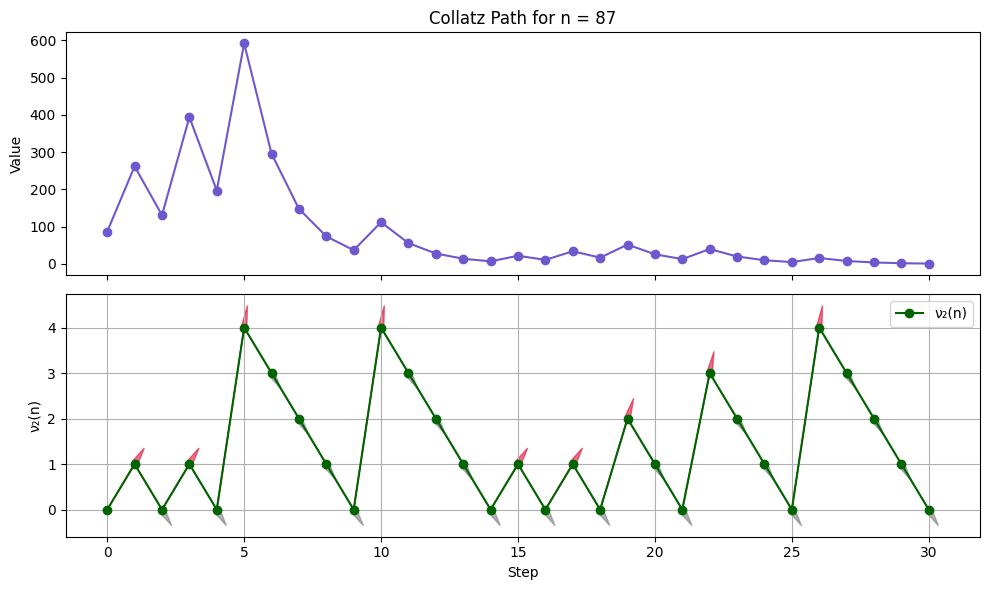

Saved: images/trajectory_cluster_5_n_87.png


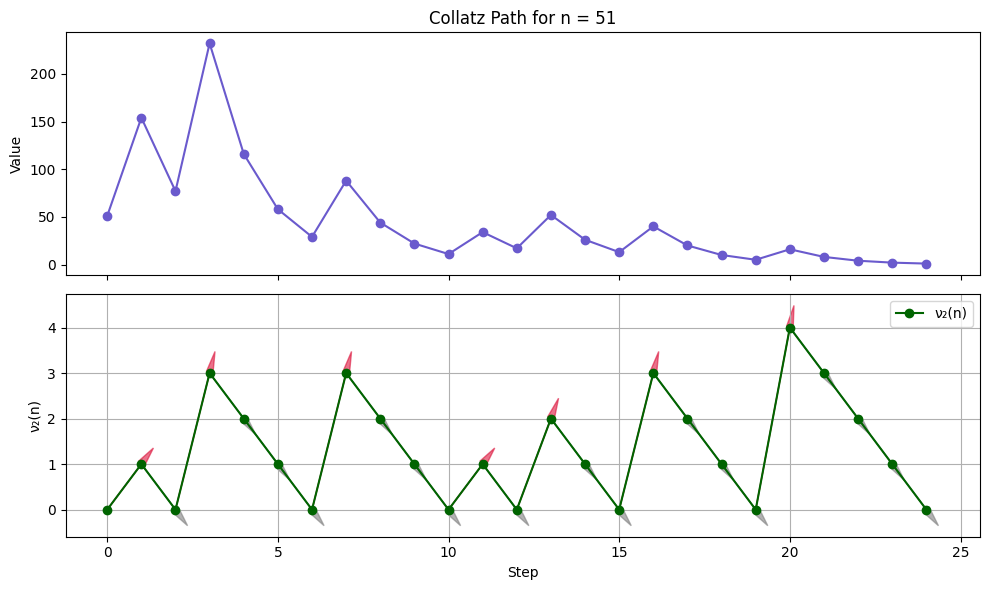

Saved: images/trajectory_cluster_5_n_51.png


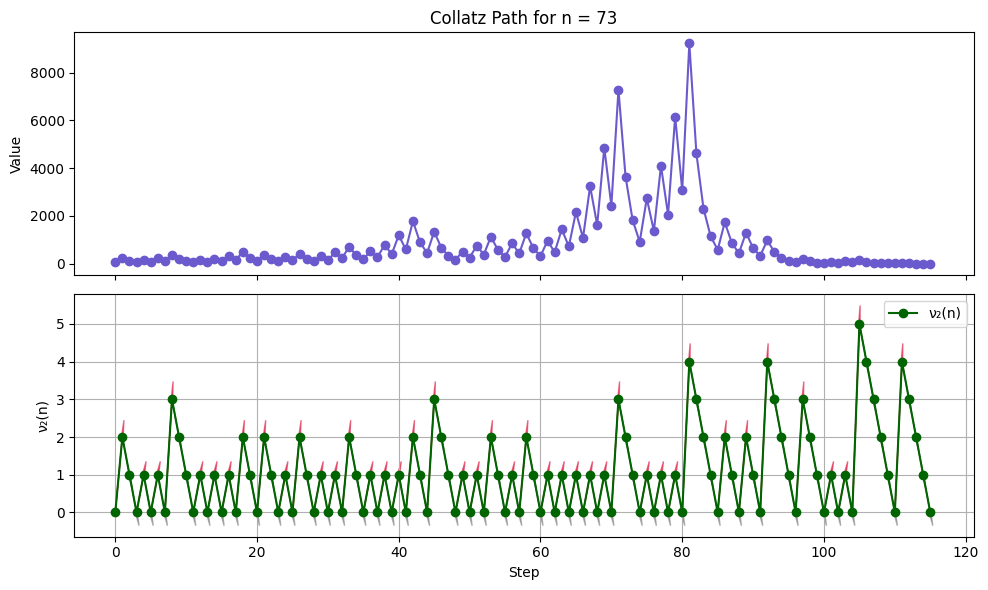

Saved: images/trajectory_cluster_0_n_73.png


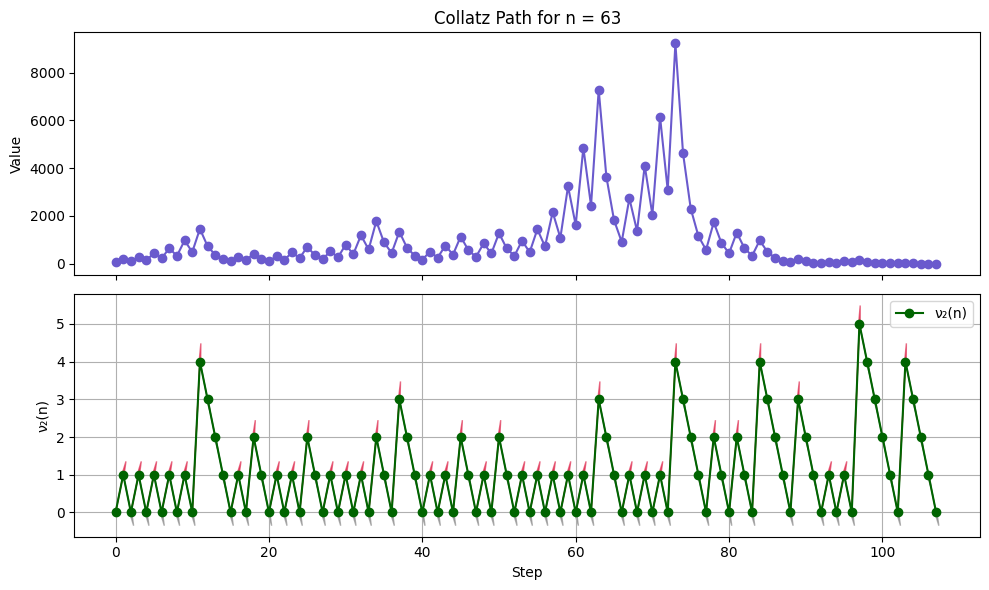

Saved: images/trajectory_cluster_0_n_63.png


In [68]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Make sure images/ folder exists
os.makedirs("images", exist_ok=True)

# Load the trajectories data
traj_df = pd.read_csv("data/collatz_trajectories.csv")

def plot_trajectory(n_start, cluster_id=None, show_entropy=True):
    # Get the trajectory data for the given n_start
    row = traj_df[traj_df["n_start"] == n_start].copy()

    # Create the figure and axes
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot 1: Value evolution
    axs[0].plot(row["step"], row["value"], marker='o', color='slateblue')
    axs[0].set_ylabel("Value")
    axs[0].set_title(f"Collatz Path for n = {n_start}")

    # Plot 2: 2-adic valuation
    axs[1].plot(row["step"], row["nu2"], marker='o', color='darkgreen', label="ν₂(n)")

    # Optionally show entropy (change of ν2 between steps)
    if show_entropy:
        for i in range(1, len(row)):
            delta = row.iloc[i]["nu2"] - row.iloc[i-1]["nu2"]
            color = 'crimson' if delta > 0 else 'gray'
            axs[1].arrow(
                row.iloc[i-1]["step"], row.iloc[i-1]["nu2"],
                dx=1, dy=delta,
                head_width=0.2, head_length=0.5, color=color, alpha=0.6
            )

    # Set labels and legends
    axs[1].set_ylabel("ν₂(n)")
    axs[1].set_xlabel("Step")
    axs[1].legend()
    axs[1].grid(True)

    # Tighten layout and save the image
    plt.tight_layout()

    # Save image before showing it
    suffix = f"_cluster_{cluster_id}" if cluster_id is not None else ""
    filename = f"images/trajectory{suffix}_n_{n_start}.png"
    plt.savefig(filename, dpi=150)  # Save the figure first
    plt.show()  # Show the plot (optional)
    plt.close()  # Close the figure to avoid overlap on the next plot

    print(f"Saved: {filename}")

# Sample 2 from each cluster (except noise)
for cluster_id in df_meta["cluster"].unique():
    if cluster_id == -1:
        continue
    # Sample 2 n_start values from the current cluster
    sample_ns = df_meta[df_meta["cluster"] == cluster_id]["n_start"].sample(n=2, random_state=cluster_id)
    for n in sample_ns:
        plot_trajectory(int(n), cluster_id=cluster_id)


In [61]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Choose your starting value
n_start = 27  # or 73 or any wild one

# Load the full trajectory
df = pd.read_csv("data/collatz_trajectories.csv")
row = df[df["n_start"] == n_start].copy().reset_index()

# Prep data
steps = row["step"]
values = row["value"]
nu2s = row["nu2"]

fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

def update(frame):
    axs[0].cla()
    axs[1].cla()

    # Value trajectory
    axs[0].plot(steps[:frame+1], values[:frame+1], marker='o', color='slateblue')
    axs[0].set_ylabel("Value")
    axs[0].set_title(f"n = {n_start}, Step = {steps[frame]}")

    # ν₂ trajectory
    axs[1].plot(steps[:frame+1], nu2s[:frame+1], marker='o', color='darkgreen')
    axs[1].set_ylabel("ν₂(n)")
    axs[1].set_xlabel("Step")

    # Optional: show entropy arrows
    for i in range(1, frame+1):
        delta = nu2s[i] - nu2s[i-1]
        color = 'crimson' if delta > 0 else 'gray'
        axs[1].arrow(
            steps[i-1], nu2s[i-1],
            dx=1, dy=delta,
            head_width=0.2, head_length=0.5, color=color, alpha=0.6
        )

    axs[0].grid(True)
    axs[1].grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(steps), interval=250, repeat=False)

# Save animation
ani.save(f"images/collatz_n_{n_start}_animated.gif", writer="pillow", fps=4)
plt.close()
print(f"Saved: images/collatz_n_{n_start}_animated.gif")


Saved: images/collatz_n_27_animated.gif


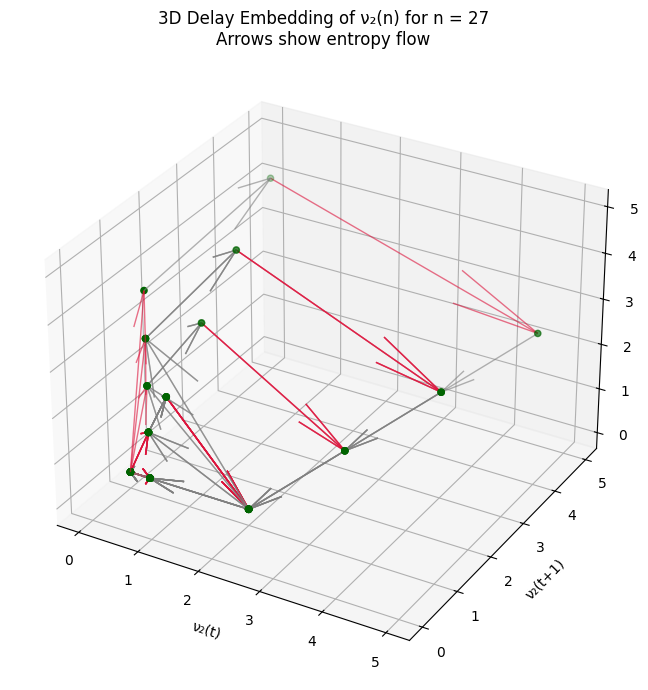

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load your full trajectory data
df = pd.read_csv("data/collatz_trajectories.csv")

# Extract trajectory for n = 27
row = df[df["n_start"] == 27].copy().reset_index()

# Extract 2-adic valuations
nu2 = row["nu2"].to_numpy()

# Build delay embedding: (ν₂_t, ν₂_{t+1}, ν₂_{t+2})
delay_dim = 3
coords = np.array([nu2[i:i+delay_dim] for i in range(len(nu2) - delay_dim)])

# Compute flow vectors: direction of next step
vectors = coords[1:] - coords[:-1]
coords = coords[:-1]  # Align vectors with their base points

# Optional: color by Δν₂ or norm of vector
color = np.sign(vectors[:, 0])  # Red for entropy injection, gray for collapse
cmap = np.array(['gray' if x <= 0 else 'crimson' for x in color])

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot base points
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='darkgreen', s=20, label='ν₂ delay points')

# Plot arrows (entropy flow)
for i in range(len(coords)):
    ax.quiver(
        coords[i, 0], coords[i, 1], coords[i, 2],
        vectors[i, 0], vectors[i, 1], vectors[i, 2],
        color=cmap[i], alpha=0.6, linewidth=1
    )

ax.set_xlabel("ν₂(t)")
ax.set_ylabel("ν₂(t+1)")
ax.set_zlabel("ν₂(t+2)")
ax.set_title("3D Delay Embedding of ν₂(n) for n = 27\nArrows show entropy flow")
plt.tight_layout()
plt.savefig("images/nu2_3d_delay_embedding_n_27.png", dpi=150)
plt.show()


In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import os

# Make sure your output folder exists
os.makedirs("images", exist_ok=True)

# Load trajectory for n = 27
df = pd.read_csv("data/collatz_trajectories.csv")
row = df[df["n_start"] == 27].copy().reset_index()
nu2 = row["nu2"].to_numpy()

# Build delay embedding
coords = np.array([nu2[i:i+3] for i in range(len(nu2) - 3)])
vectors = coords[1:] - coords[:-1]
coords = coords[:-1]  # Align lengths

# Color by entropy injection
colors = np.array(['crimson' if v[0] > 0 else 'gray' for v in vectors])

# Create figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.set_xlim(0, np.max(nu2))
    ax.set_ylim(0, np.max(nu2))
    ax.set_zlim(0, np.max(nu2))
    ax.set_xlabel("ν₂(t)")
    ax.set_ylabel("ν₂(t+1)")
    ax.set_zlabel("ν₂(t+2)")
    ax.set_title(f"3D Delay Embedding of ν₂(n=27), Frame {frame + 1}")

    # Plot all points so far
    ax.scatter(coords[:frame+1, 0], coords[:frame+1, 1], coords[:frame+1, 2], c='darkgreen', s=20)

    # Plot vectors up to current frame
    for i in range(min(frame + 1, len(vectors))):
        ax.quiver(
            coords[i, 0], coords[i, 1], coords[i, 2],
            vectors[i, 0], vectors[i, 1], vectors[i, 2],
            color=colors[i], alpha=0.6, linewidth=1
        )

    # Optional: rotate the view slowly
    ax.view_init(elev=30, azim=frame * 4)

ani = animation.FuncAnimation(fig, update, frames=len(coords), interval=200, repeat=False)

# Save as GIF
ani.save("images/nu2_3d_delay_embedding_n_27_animated.gif", writer="pillow", fps=5)
plt.close()

print("Saved: images/nu2_3d_delay_embedding_n_27_animated.gif")


Saved: images/nu2_3d_delay_embedding_n_27_animated.gif


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import os

# Ensure the output folder exists
os.makedirs("images", exist_ok=True)

# Load trajectory for n = 27
df = pd.read_csv("data/collatz_trajectories.csv")
row = df[df["n_start"] == 27].copy().reset_index()
values = row["value"].to_numpy()

# Build delay embedding for raw values (x_t, x_{t+1}, x_{t+2})
coords = np.array([values[i:i+3] for i in range(len(values) - 3)])
vectors = coords[1:] - coords[:-1]  # Compute vectors between successive points
coords = coords[:-1]  # Align lengths for vector flow

# Color by entropy flux: red = entropy injection, gray = compression
colors = np.array(['crimson' if v[0] > 0 else 'gray' for v in vectors])

# Create figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.set_xlim(0, np.max(values))
    ax.set_ylim(0, np.max(values))
    ax.set_zlim(0, np.max(values))
    ax.set_xlabel("Value(t)")
    ax.set_ylabel("Value(t+1)")
    ax.set_zlabel("Value(t+2)")
    ax.set_title(f"3D Delay Embedding of Raw Collatz Values for n=27, Frame {frame + 1}")

    # Plot points up to the current frame
    ax.scatter(coords[:frame+1, 0], coords[:frame+1, 1], coords[:frame+1, 2], c='darkgreen', s=20)

    # Plot arrows (entropy flow)
    for i in range(min(frame + 1, len(vectors))):
        ax.quiver(
            coords[i, 0], coords[i, 1], coords[i, 2],
            vectors[i, 0], vectors[i, 1], vectors[i, 2],
            color=colors[i], alpha=0.6, linewidth=1
        )

    # Optional: rotate view for animation
    ax.view_init(elev=30, azim=frame * 4)

ani = animation.FuncAnimation(fig, update, frames=len(coords), interval=200, repeat=False)

# Save as GIF
ani.save("images/raw_values_3d_delay_embedding_n_27_animated.gif", writer="pillow", fps=5)
plt.close()

print("Saved: images/raw_values_3d_delay_embedding_n_27_animated.gif")


Saved: images/raw_values_3d_delay_embedding_n_27_animated.gif


In [66]:
import pandas as pd

# Load full trajectories
df = pd.read_csv("data/collatz_trajectories.csv")

# Group by starting value
summary = []

for n_start, group in df.groupby("n_start"):
    steps_to_1 = group["step"].max()
    max_value = group["value"].max()
    nu2_0 = group.iloc[0]["nu2"]
    delta_nu2_total = group["delta_nu2"].sum()
    
    summary.append({
        "n_start": n_start,
        "steps_to_1": steps_to_1,
        "max_value": max_value,
        "nu2_0_mean": nu2_0,
        "delta_nu2_total_mean": delta_nu2_total
    })

# Save
meta_df = pd.DataFrame(summary)
meta_df.to_csv("data/meta_summary.csv", index=False)
print("✅ Saved meta summary to data/meta_summary.csv")


✅ Saved meta summary to data/meta_summary.csv
